In [25]:
import torch
import torch.nn as nn
import torch.functional as F
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import Adam, AdamW, SGD
from tqdm import tqdm

In [26]:
def objective(x, y):
    return torch.sin(x + y) + (x-y)**2 -1.5*x + 2.5*y + 1

min_coord = (-0.5472, -1.5472)
min_val = -1.913

lr = 1e-1
weight_decay = 2e-1
optimizers = [
    lambda x: Adam(x, lr=lr), 
    lambda x: AdamW(x, lr=lr, weight_decay=weight_decay),
    lambda x: SGD(x, lr=lr)
]

starting = [
    (torch.tensor(-4.,  requires_grad=True), torch.tensor(4., requires_grad=True)),
    (torch.tensor(-4.,  requires_grad=True), torch.tensor(4., requires_grad=True)),
    (torch.tensor(-4.,  requires_grad=True), torch.tensor(4., requires_grad=True)),
]

opt_vals = []
for i, opt in enumerate(tqdm(optimizers)):
    a, b = starting[i]
    opt = opt([a, b])
    opt_val_i = []
    opt_val_i.append([a.item(), b.item()])

    l = float("inf")
    while l > min_val:
        opt.zero_grad()
        l = objective(a, b)
        l.backward()
        opt.step()
        opt_val_i.append([a.item(), b.item()])
    opt_vals.append(opt_val_i)

100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]


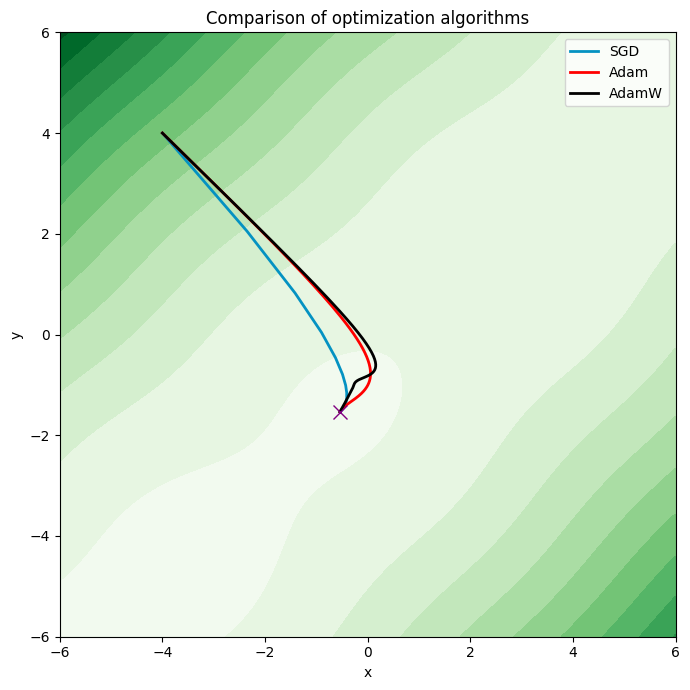

In [27]:
r_min, r_max = -6.0, 6.0
xaxis = np.arange(r_min, r_max, 0.01)
yaxis = np.arange(r_min, r_max, 0.01)

x, y = np.meshgrid(xaxis, yaxis)
results = objective(torch.tensor(x), torch.tensor(y))
s = 20

adam = np.array(opt_vals[0])
adamw = np.array(opt_vals[1])
sgd = np.array(opt_vals[2])

plt.figure(figsize=(7, 7))
plt.plot(sgd[:, 0], sgd[:, 1], c="#0492C2", label="SGD", linewidth=2)
plt.plot(adam[:, 0], adam[:, 1], c="red", label="Adam", linewidth=2)
plt.plot(adamw[:, 0], adamw[:, 1], c="black", label="AdamW", linewidth=2)
plt.plot([min_coord[0]], [min_coord[1]], marker="x", markersize=10, c="purple")
plt.xlim([r_min, r_max])
plt.ylim([r_min, r_max])
plt.title("Comparison of optimization algorithms")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.legend()
plt.contourf(x, y, results, levels=15, cmap="Greens")
plt.savefig("../figures/optimization_plot.png")
plt.show()

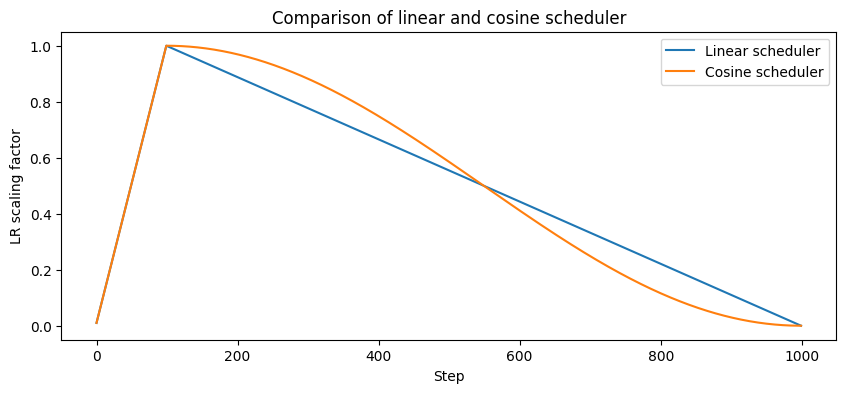

In [48]:
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup
from torch.optim import SGD

num_steps = 1000
warmup_ratio = 0.1

dummy_vector = torch.tensor([0.], requires_grad=True)
dummy_optimizer = SGD([dummy_vector], lr=1)

linear = get_linear_schedule_with_warmup(
    dummy_optimizer,
    num_warmup_steps=int(warmup_ratio*num_steps),
    num_training_steps=num_steps
)

cosine = get_cosine_schedule_with_warmup(
    dummy_optimizer,
    num_warmup_steps=int(warmup_ratio*num_steps),
    num_training_steps=num_steps
)

#cosine2 = get_cosine_with_hard_restarts_schedule_with_warmup(
#    dummy_optimizer,
#    num_warmup_steps=int(warmup_ratio*num_steps),
#    num_training_steps=num_steps,
#    num_cycles=3
#)

plt.figure(figsize=(10, 4))
plt.title("Comparison of linear and cosine scheduler")
plt.xlabel("Step")
plt.ylabel("LR scaling factor")

lin_steps, cos_steps, cos2_steps = [], [], []
for k in range(num_steps):
    linear.step()
    cosine.step()
#    cosine2.step()
    lin_steps.append(linear.get_last_lr())
    cos_steps.append(cosine.get_last_lr())
#    cos2_steps.append(cosine2.get_last_lr())

plt.plot(list(range(len(lin_steps))), lin_steps, label="Linear scheduler")
plt.plot(list(range(len(cos_steps))), cos_steps, label="Cosine scheduler")
#plt.plot(list(range(len(cos2_steps))), cos2_steps, label="Cosine scheduler with hard restarts")
plt.legend()
plt.savefig("../figures/scheduler_plot.png")
plt.show()